## FashionMNIST Classification Model

GPU Setting

In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data load

In [3]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
trainset = datasets.FashionMNIST(root='./datasets/', train=True, download=True, transform=transforms)
testset = datasets.FashionMNIST(root='./datasets/', train=False, download=True, transform=transforms)

0it [00:00, ?it/s]

Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw
Processing...
Done!


/home/hwan/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [7]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

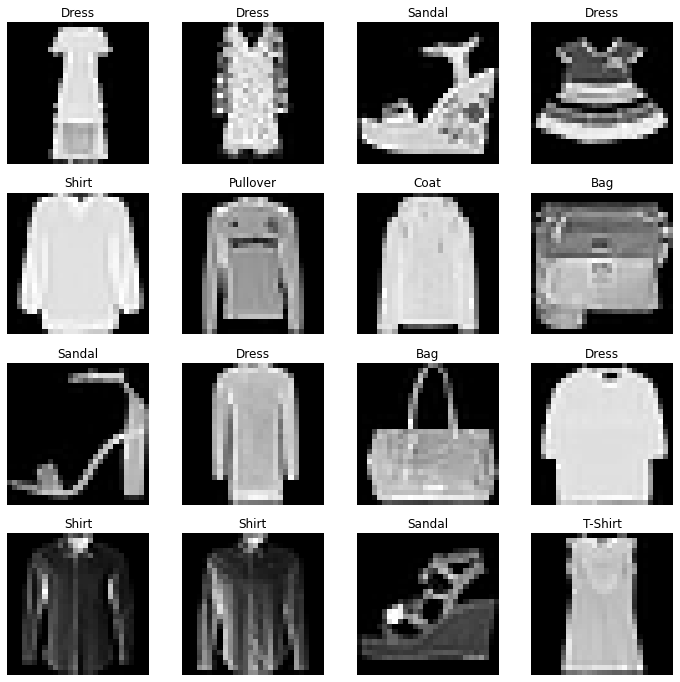

In [12]:
import matplotlib.pyplot as plt

labels_map = {
    0 : 'T-Shirt',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat', 
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneakers',
    8 : 'Bag',
    9 : 'Ankle Boots',
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    image = images[i].squeeze()
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

### Define Model

In [21]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [22]:
params = list(model.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [23]:
ex = torch.randn(1, 1, 28, 28)
out = model(ex)
print(out)

tensor([[-0.0637,  0.1300, -0.0312, -0.1101,  0.1028, -0.0065,  0.0891,  0.1392,
         -0.0106, -0.0712]], grad_fn=<AddmmBackward>)


### Loss function & Optimizer

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Model Train
Check batch size

In [27]:
total_batch = len(train_loader)
print(total_batch)

469


In [28]:
for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs= model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'Epoch : {epoch+1}, Iteration : {i+1}, Loss : {running_loss}')
            running_loss = 0

Epoch : 1, Iteration : 100, Loss : 230.01805329322815
Epoch : 1, Iteration : 200, Loss : 229.05241918563843
Epoch : 1, Iteration : 300, Loss : 227.6648006439209
Epoch : 1, Iteration : 400, Loss : 224.73610067367554
Epoch : 2, Iteration : 100, Loss : 200.24626243114471
Epoch : 2, Iteration : 200, Loss : 148.55278205871582
Epoch : 2, Iteration : 300, Loss : 105.76956832408905
Epoch : 2, Iteration : 400, Loss : 88.32116764783859
Epoch : 3, Iteration : 100, Loss : 77.38096457719803
Epoch : 3, Iteration : 200, Loss : 73.59360468387604
Epoch : 3, Iteration : 300, Loss : 70.69871830940247
Epoch : 3, Iteration : 400, Loss : 68.50148540735245
Epoch : 4, Iteration : 100, Loss : 65.25583153963089
Epoch : 4, Iteration : 200, Loss : 65.56520295143127
Epoch : 4, Iteration : 300, Loss : 63.180832386016846
Epoch : 4, Iteration : 400, Loss : 62.76606202125549
Epoch : 5, Iteration : 100, Loss : 61.27871188521385
Epoch : 5, Iteration : 200, Loss : 60.37268042564392
Epoch : 5, Iteration : 300, Loss : 59.3

### Model save & load
- `torch.save` : `net.state_dict()`를 저장
- `torch.load` : `load_state_dict()`로 모델을 load

In [29]:
PATH = './09 exercise2.pth'
torch.save(model.state_dict(), PATH)

In [30]:
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [32]:
model.parameters

<bound method Module.parameters of CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

### Model Test

In [33]:
import numpy as np

def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()

    fig = plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

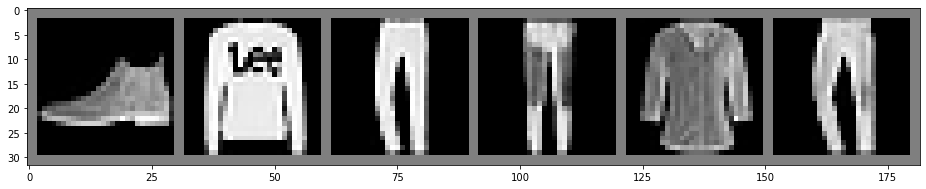

In [34]:
import torchvision

dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:6]))

In [35]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 6, 8, 0, 2, 7, 7, 5,
        1, 6, 6, 0, 9, 4, 8, 8, 3, 6, 8, 0, 7, 5, 7, 9, 0, 1, 6, 9, 6, 7, 6, 1,
        2, 6, 6, 4, 5, 8, 4, 2, 8, 6, 8, 0, 7, 7, 8, 5, 1, 1, 0, 4, 7, 8, 7, 0,
        2, 6, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 6, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2, 3, 4, 7, 6, 7, 8, 5, 9, 9, 4, 6, 5, 7, 0, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4])


In [37]:
print(''.join('{}, '.format(labels_map[int(predicted[j].numpy())]) for j in range(6)))

Ankle Boots, Pullover, Trouser, Trouser, Shirt, Trouser, 


In [38]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy : {100 * correct / total}')

Accuracy : 81.18
